# Testing regularization of likelihood functions

In [1]:
%pylab inline
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
sys.path.append('../../utils/flowpm/')

In [4]:
from matplotlib.colors import LogNorm

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


In [6]:
import numpy as np
import numpy, os
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
from  astropy.cosmology import Planck15
from background import MatterDominated, RadiationDominated



def cic_paint(mesh, part, weight=None, cube_size=None, boxsize=None, name=None):
    """                                                                                                                                                                                                                                                                                   
        - mesh is a cube of format tf.Variable                                                                                                                                                                                                                                            
        - part is a list of particles (:, 3), positions assumed to be in                                                                                                                                                                                                                  
    mesh units if boxsize is None                                                                                                                                                                                                                                                         
        - weight is a list of weights (:)                                                                                                                                                                                                                                                 
        - cube_size is the size of the cube in mesh units                                                                                                                                                                                                                                 
    """

    if cube_size is None: cube_size = int(mesh.shape[0].value)
    if boxsize is not None:
        part = tf.multiply(part, cube_size/boxsize)

    # Extract the indices of all the mesh points affected by each particles                                                                                                                                                                                                               
    part = tf.expand_dims(part, 1)
    floor = tf.floor(part)
    connection = tf.constant([[[0,], [1., ]]])
    neighboor_coords = tf.add(floor, connection)

    kernel = 1. - tf.abs(part - neighboor_coords)
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    if weight is not None: kernel = tf.multiply(tf.expand_dims(weight, axis=1) , kernel)

    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.mod(neighboor_coords , cube_size)

    update = tf.scatter_nd(neighboor_coords, kernel, [cube_size])
    mesh = tf.add(mesh, update, name=name)
    return mesh

def cic_readout(mesh, part, cube_size=None, boxsize=None):
    """                                                                                                                                                                         
        - mesh is a cube                                                                                                                                                        
        - part is a list of particles (:, 3), positions assumed to be in                                                                                                        
    mesh units if boxsize is None                                                                                                                                               
        - cube_size is the size of the cube in mesh units                                                                                                                       
    """

    if cube_size is None: cube_size = int(mesh.shape[0].value)
    if boxsize is not None:
        part = tf.multiply(part, cube_size/boxsize)

    # Extract the indices of all the mesh points affected by each particles                                                                                                     
    part = tf.expand_dims(part, 1)
    floor = tf.floor(part)
    connection = tf.constant([[[0,], [1.]]])
    neighboor_coords = tf.add(floor, connection)
    
    kernel = 1. - tf.abs(part - neighboor_coords)    
    kernel = tf.reduce_prod(kernel, axis=-1, keepdims=False)
    
    neighboor_coords = tf.cast(neighboor_coords, tf.int32)
    neighboor_coords = tf.mod(neighboor_coords , cube_size)
    meshvals = tf.gather_nd(mesh, neighboor_coords)
#     return meshvals
    weightedvals = tf.multiply(meshvals, kernel)
    value = tf.reduce_sum(weightedvals, axis=1)
    return value

def laplace(config):
    kvec = config['kvec']
    kk = 0
    for k in config['kvec']:
        kk = kk + k**2
#     kk = np.sum(ki**2 for ki in kvec)
    mask = (kk == 0).nonzero()
    kk[mask] = 1
    wts = 1/kk
    imask = (~(kk==0)).astype(int)
    wts *= imask
    return wts



def gradient(config, dir):
    kvec = config['kvec']
    bs, nc = config['boxsize'], config['nc']
    cellsize = bs/nc
    w = kvec[dir] * cellsize
    a = 1 / (6.0 * cellsize) * (8 * numpy.sin(w) - numpy.sin(2 * w))
    wts = a*1j
    return wts


def r2c(rfield, norm=None, dtype=tf.complex64, name=None):
    if norm is None: norm = tf.cast(tf.reduce_prod(tf.shape(rfield)), dtype)
    else: norm = tf.cast(norm, dtype)
    cfield = tf.multiply(tf.spectral.fft(tf.cast(rfield, dtype)), 1/norm, name=name)
    return cfield


def c2r(cfield, norm=None, dtype=tf.float32, name=None):
    if norm is None: norm = tf.cast(tf.reduce_prod(tf.shape(cfield)), dtype)
    else: norm = tf.cast(norm, dtype)
    rfield = tf.multiply(tf.cast(tf.spectral.ifft(cfield), dtype), norm, name=name)
    return rfield


def fftk(shape, boxsize, symmetric=True, finite=False, dtype=np.float64):
    """ return k_vector given a shape (nc, nc, nc) and boxsize                                                                                                                  
    """
    k = []
    for d in range(len(shape)):
        kd = numpy.fft.fftfreq(shape[d])
        kd *= 2 * numpy.pi / boxsize * shape[d]
        kdshape = numpy.ones(len(shape), dtype='int')
        if symmetric and d == len(shape) -1:
            kd = kd[:shape[d]//2 + 1]
        kdshape[d] = len(kd)
        kd = kd.reshape(kdshape)

        k.append(kd.astype(dtype))
    del kd, kdshape
    return k


def genwhitenoise(nc, seed, type='complex'):
    white = tf.random_normal(shape=(nc,), mean=0, stddev=nc**0.5, seed=seed)
    if type == 'real': return white
    elif type == 'complex':
        whitec = r2c(white, norm=nc)
        return whitec


def linfield(config, seed=100, name='linfield'):
    '''generate a linear field with a given linear power spectrum'''

    bs, nc = config['boxsize'], config['nc']
    kmesh = 0
    for k in config['kvec']:
        kmesh = kmesh + k**2
    kmesh = kmesh**0.5
#     kmesh = np.sum(kk**2 for kk in config['kvec'])**0.5
    pkmesh = config['ipklin'](kmesh)

    whitec = genwhitenoise(nc, seed, type='complex')
    lineark = tf.multiply(whitec, (pkmesh/bs**3)**0.5)
    linear = c2r(lineark, norm=nc, name=name)
    return linear


def lpt1(dlin_k, pos, config):
    """ Run first order LPT on linear density field, returns displacements of particles                                                                                         
        reading out at q. The result has the same dtype as q.                                                                                                                   
    """
    bs, nc = config['boxsize'], config['nc']
    #ones = tf.ones_like(dlin_k)                                                                                                                                                
    lap = laplace(config)

    displacement = tf.zeros_like(pos)
    displacement = []
    for d in range(config['ndim']):
        kweight = gradient(config, d) * lap
        dispc = tf.multiply(kweight, dlin_k)
        disp = c2r(dispc, norm=nc)
        displacement.append(cic_readout(disp, pos, boxsize=bs))

    return tf.stack(displacement, axis=1)




def lptz0(lineark, config, a=1, order=2):
    '''one step 2 LPT displacement to z=0'''
    bs, nc = config['boxsize'], config['nc']
    pos = config['grid']

    DX1 = 1 * lpt1(lineark, pos, config)

    if order == 2: 
#         DX2 = 1 * tflpt1(tflpt2source(lineark, config), pos, config)
        return None
    else: DX2 = 0
    return tf.add(DX1 , DX2)


class Config1d(dict):
    def __init__(self, bs=100., nc=16, seed=100, B=1, stages=None, cosmo=None,
                 pkfile=None, pkinitfile=None, dtype=np.float32):

        self['dtype'] = dtype
        self['boxsize'] = dtype(bs)
        self['shift'] = 0.0
        self['nc'] = int(nc)
        self['kny'] = np.pi*nc/bs
        self['ndim'] = 1
        self['seed'] = seed
        self['pm_nc_factor'] = B
        self['resampler'] = 'cic'
        #                                                                                                                                                                       
        self['cosmology'] = Planck15
        if stages is None: stages = numpy.linspace(0.1, 1.0, 5, endpoint=True)
        self['stages'] = stages
        self['aout'] = [1.0]
        self['perturbation'] = MatterDominated(cosmo=self['cosmology'], a=self['stages'])
        #self['perturbation'] = RadiationDominated(cosmo=self['cosmology'], a=self['stages'])                                                                                   
        #                                                                                                                                                                       
        self['kvec'] = fftk(shape=(nc, ), boxsize=bs, symmetric=False, dtype=dtype)
        self['grid'] = bs/nc*np.indices((nc, )).reshape(1, -1).T.astype(dtype)
        self['pkfile'] = '../../utils/flowpm/Planck15_a1p00.txt'
        self['klin'] = np.loadtxt(self['pkfile']).T[0]
        self['plin'] = np.loadtxt(self['pkfile']).T[1]
        self['ipklin'] = iuspline(self['klin'], self['plin'])
        #                                                        

In [7]:

def power(f1, f2=None, boxsize=1.0, k = None):
    """                                                                                                                                     
    Calculate power spectrum given density field in real space & boxsize.                                                                   
    Divide by mean, so mean should be non-zero                                                                                              
    """
#    f1 = f1[::2, ::2, ::2]                                                                                                                 
    c1 = numpy.fft.rfft(f1)
    c1 /= c1[0].real
    c1[0] = 0
    if f2 is not None:
        c2 = numpy.fft.rfft(f2)
        c2 /= c2[0].real
        c2[0] = 0
    else:
        c2 = c1
    #x = (c1 * c2.conjugate()).real                                                                                                         
    x = c1.real* c2.real + c1.imag*c2.imag
    del c1
    del c2
    if k is None:
        k = fftk(f1.shape, boxsize, symmetric=True)
        k = sum(kk**2 for kk in k)**0.5
    H, edges = numpy.histogram(k.flat, weights=x.flat, bins=f1.shape[0])
    N, edges = numpy.histogram(k.flat, bins=edges)
    H = H[::2]
    N = N[::2]
    edges = edges[::2]
    center= edges[1:] + edges[:-1]

    return 0.5 * center, H *boxsize**3/ N

In [8]:
from time import time

In [8]:
# start = time()
# tf.reset_default_graph()
# inits, fins = [], []

# bs = 100.
# nc = 100
# config = Config1d(bs=bs, nc=nc)
# for ii in range(1):
#     if ii%1000==0: print(ii)
#     tf.reset_default_graph()
#     lf_t = linfield(config, seed=ii)
#     lfk_t = r2c(lf_t, norm=nc)
#     za_t = lptz0(lfk_t, config, order=1)
#     final_t = tf.zeros_like(lf_t)
#     zaf_t = cic_paint(final_t, za_t, boxsize=bs, name='final')
#     test = cic_readout(lf_t, config['grid'],cube_size=nc, boxsize=bs)
#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
#         lf = sess.run(lf_t)
#         za = sess.run(za_t)
#         zaf = sess.run(zaf_t)
#         test = sess.run(test)
# #     inits.append(lf.copy())
# #     fins.append(za.copy())


# # print(time() - start)

In [8]:
# import tfpm1d
# tf.reset_default_graph()


# bs = 100.
# nc = 128
# side = bs/nc
# config = tfpm1d.Config1d(bs=bs, nc=nc)
# def pm(config, verbose=True):
#     g = tf.Graph()
#     with g.as_default():
#         linear = tfpm1d.linfield(config, name='linear')
#         icstate = tfpm1d.lptinit(linear, config, name='icstate')
#         fnstate = tfpm1d.nbody(icstate, config, verbose=verbose, name='fnstate')
#         final = tf.zeros_like(linear)
#         final = tfpm1d.cic_paint(final, fnstate[0], boxsize=bs, name='final')
#         tf.add_to_collection('pm', [linear, icstate, fnstate, final])
#     return g

# g = pm(config)

# with tf.Session(graph=g) as sess:
#     sess.run(tf.global_variables_initializer())
#     linear = g.get_tensor_by_name('linear:0')
#     final = g.get_tensor_by_name('final:0')
#     fnstate = g.get_tensor_by_name('fnstate:0')
#     icstate = g.get_tensor_by_name('icstate:0')
#     linmesh, finmesh, fstate,istate = sess.run([linear, final, fnstate, icstate])
# #     linmesh, finmesh, fstate,istate = sess.run([linear, final, fnstate, icstate])                                                                                                                                                                                                       


#############FOF

# pos = fstate[0].flatten()
# def merge(x1, x2, r=side/2):
#     if abs(x1-x2) < r:
#         return True
#     else: return False
    
# hpos, hmass = [], []
# i = 0 
# while i < pos.size-1:
#     length=1
#     com=pos[i]
#     while merge(pos[i], pos[i+1]):
#         if length==1:print('merge at ', i)
#         length += 1
#         com+= pos[i+1]
#         i+=1
#     if length>1:
#         hpos.append(np.array(com).sum()/length)
#         hmass.append(length)
#     i+=1
    
# hpos, hmass



# plt.plot(linmesh)
# plt.plot(finmesh-1)
# rates = 2*np.array(list(map(max, finmesh-1, finmesh*0)))
# plt.plot(np.random.poisson(rates), '--')
# tmp = np.histogram(pos, bins=int(nc))
# plt.plot(tmp[1][:-1]*nc/bs, tmp[0]-1, alpha=0.5)
# for i in hpos:
#     plt.axvline(i*nc/bs, color='k')
# # plt.show()

In [10]:
tf.reset_default_graph()

bs = 100.
nc = 50
config = Config1d(bs=bs, nc=nc)
kmesh = 0
for k in config['kvec']:
    kmesh = kmesh + k**2
kmesh = kmesh**0.5
#     kmesh = np.sum(kk**2 for kk in config['kvec'])**0.5
pkmesh = config['ipklin'](kmesh)


def module_fn():
    '''Define network here'''
    init = tf.placeholder(tf.float32, shape=[nc], name='input')
    
    init_k = r2c(init)
    init_kp = tf.multiply(init_k,  (pkmesh/bs**3)**0.5)
    lin = c2r(init_kp)
    lap = laplace(config)
    kweight = gradient(config, 0) * lap
    dispc = tf.multiply(kweight, init_kp)
    disp = c2r(dispc)
    za_t = tf.stack([cic_readout(disp, config['grid'], boxsize=bs)], axis=1)    
#     za_t = lptz0(init_k, config, order=1)
    
    fp_t = tf.add(za_t, config['grid'])
    zaf_t = tf.zeros_like(init)
    zaf_t = cic_paint(zaf_t, fp_t, boxsize=bs, name='final')
    test_rd = cic_readout(lin, config['grid'], boxsize=bs)
    test_pt = tf.zeros_like(init)
    test_pt = cic_paint(test_pt, config['grid'], weight=test_rd, boxsize=bs)
    
    #

    hub.add_signature(inputs={'init':init}, 
                          outputs={'linfield':lin, 'zadisp':za_t, 'zafield':zaf_t, 
                                   'testpt':test_pt, 'testrd':test_rd   })
    
#####                                                                                                                                                                                                                                                                                     


# spec = hub.create_module_spec(module_fn)
# module = hub.Module(spec, trainable=True)


# xx = tf.placeholder(tf.float32, shape=[nc], name='input')
# linf_t = module({'init':xx}, as_dict=True)['linfield']
# zaf_t = module({'init':xx}, as_dict=True)['zafield']
# zad_t = module({'init':xx}, as_dict=True)['zadisp']
# test_pt = module({'init':xx}, as_dict=True)['testpt']
# test_rd = module({'init':xx}, as_dict=True)['testrd']


# data_size = 10000
# initgs = np.random.normal(loc=0, scale=nc**0.5, size = nc*data_size).astype('float32').reshape(data_size, nc)
# fins = []
# lins = []
# za = []
# tests = []
# start = time()
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     for ii in range(data_size):
#         lin, fin, disp = sess.run([linf_t, zaf_t,  zad_t], feed_dict={xx:initgs[ii]})
#         lins.append(lin)
#         fins.append(fin-1)
#         za.append(disp)
#         tests.append(sess.run([test_pt, test_rd], feed_dict={xx:initgs[ii]}))
        
# print(time() - start)

In [159]:
# lins = np.array(lins)
# fins = np.array(fins)
# za = np.array(za)

# ii = 1
# # plt.plot(initgs[ii], ':')
# plt.plot(lins[ii], label="linear")
# plt.plot(fins[ii], label="za")
# plt.legend()

In [164]:
# np.save('./za1d_data', np.stack((lins, fins)))

In [11]:
bs = 100.
nc = 50
config = Config1d(bs=bs, nc=nc)

In [12]:
inits, fins = np.load('./za1d_data.npy')
nc = inits.shape[1]

In [36]:
bias = 3
rates = fins.copy()*bias + fins.copy()**2*bias + fins.copy()**3*bias
rates[rates<0] = 0
rates[rates>4] = 4
finsample = np.random.poisson(rates)

In [37]:

inits.shape, fins.shape

((10000, 50), (10000, 50))

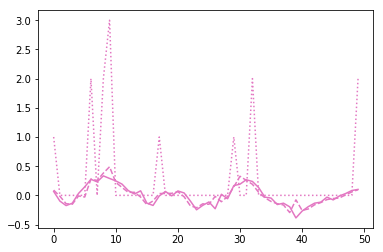

In [38]:
ii = 15
plt.plot(inits[ii], 'C%d'%(ii%9))
plt.plot(fins[ii], 'C%d--'%(ii%9))
plt.plot(finsample[ii], 'C%d:'%(ii%9))


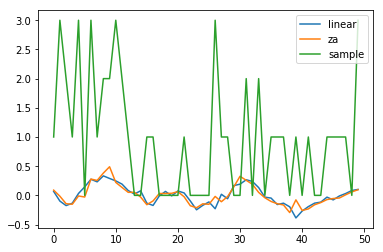

In [39]:
# plt.plot(initgs[ii], ':')
plt.plot(inits[ii], label="linear")
plt.plot(fins[ii], label="za")
plt.plot(np.random.poisson(np.exp(fins[ii])), label="sample")
plt.legend()

In [40]:
# %%bash
# ls ./modules/
# rm -r ./modules/fwdmodelza/


In [41]:
# module.export('./modules/fwdmodelza', sess)


# Module

Train a neural network in a module 

In [42]:
# tf.reset_default_graph()

# nsize = 256

# def module_fn():
#     '''Define network here'''
#     x = tf.placeholder(tf.float32, shape=[None, nc], name='input')
#     y = tf.placeholder(tf.float32, shape=[None, nc], name='output')

#     reg = tf.contrib.layers.l2_regularizer(0.01)

# #     net = tf.layers.dense(x,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
# #     net = net + tf.layers.dense(net,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
# #     net = net + tf.layers.dense(net,nsize, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
# # #     net = tf.layers.dense(net,nc, activation=tf.nn.leaky_relu, name='rate')
# #     net = tf.layers.dense(net,nc,  name='rate')

#     xx = tf.expand_dims(x, -1)
#     net = tf.layers.conv1d(xx,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8,3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = net + tf.layers.conv1d(net,8, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = tf.layers.conv1d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same')
#     net = tf.squeeze(net, name='rate')
# #     net = tf.layers.flatten(net)
# #     net = tf.layers.dense(net, nc, activation=tf.nn.leaky_relu, kernel_regularizer=reg)
# #     net = tf.layers.dense(net, nc,  name='rate')
# #     net = tf.layers.dense(net,nc, activation=tf.nn.leaky_relu, name='rate')
#     loglik = tf.reduce_sum(tf.square(tf.add(net, -y)), axis=(1))
#     #

#     hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':net, 'loglikelihood':loglik, 'rate':net})
    
# #####                                                                                                                                                                                                                                                                                     


# spec = hub.create_module_spec(module_fn)
# module = hub.Module(spec, trainable=True)


# xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
# loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
# sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
# loss = loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
# loss = tf.reduce_mean(loss)

# lr = tf.placeholder(tf.float32)
# optimizer = tf.train.AdamOptimizer(learning_rate=lr)
# train_op = optimizer.minimize(loss)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# losses =[]

# data_size = 9000
# batch_size = 32

# for i in range(5000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = fins[inds]/fins.std()
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.01})
#     losses.append(l)
#     if i%1000 ==0: print(l)
# for i in range(10000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = fins[inds]/fins.std()
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
#     losses.append(l)
#     if i%1000 ==0: print(l)
        
# # for i in range(5000):
# #     inds = np.random.randint(0, data_size, batch_size)
# #     l,_= sess.run([loss, train_op], feed_dict={xx:sx[inds], yy:sy[inds], lr:0.0005})
# #     losses.append(l)
# #     if i%1000 ==0: print(l)
# # pred = sess.run(sample, feed_dict={xx:sx})
# learn = sess.run(rate, feed_dict={xx:inits, yy:y})


In [43]:

# tf.reset_default_graph()

# nfilter = 128
# n_mixture = 1
# stddev = 0.02

# @slim.add_arg_scope
# def module_fn():
#     '''Define network here'''
#     x = tf.placeholder(tf.float32, shape=[None, nc], name='input')
#     y = tf.placeholder(tf.float32, shape=[None, nc], name='output')

#     reg = tf.contrib.layers.l2_regularizer(0.00)
#     kerninit = tf.truncated_normal_initializer(stddev=stddev)

#     with slim.arg_scope([tf.layers.conv1d],
#                                 kernel_regularizer=reg,
#                                 padding='same',
#                                 kernel_initializer=kerninit,):

#         xx = tf.expand_dims(x, -1)
#         net = tf.layers.conv1d(xx,nfilter, 5, activation=tf.nn.leaky_relu)
        
#         net = tf.nn.leaky_relu(net)
#         subnet = tf.layers.conv1d(net,nfilter, 3)
#         net = net + tf.layers.conv1d(subnet,nfilter, 3)
#         net = tf.nn.dropout(net, 0.95)

#         net = tf.nn.leaky_relu(net)
#         subnet = tf.layers.conv1d(net,nfilter, 3)
#         net = net + tf.layers.conv1d(subnet,nfilter, 3)
#         net = tf.nn.dropout(net, 0.95)

#         net = tf.nn.leaky_relu(net)
#         subnet = tf.layers.conv1d(net,nfilter, 3)
#         net = net + tf.layers.conv1d(subnet,nfilter, 3)
#         net = tf.nn.dropout(net, 0.95)

#         net = tf.nn.leaky_relu(net)
#         subnet = tf.layers.conv1d(net,nfilter, 3)
#         net = net + tf.layers.conv1d(subnet,nfilter, 3)
#         net = tf.nn.dropout(net, 0.95)

#         net = tf.layers.conv1d(net,1, 3)
#         net = tf.nn.leaky_relu(net)
#         net = tf.layers.conv1d(net, n_mixture*3, 1)

#         loc, unconstrained_scale, logits = tf.split(net,
#                                                         num_or_size_splits=3,
#                                                         axis=-1)
#         scale = tf.nn.softplus(unconstrained_scale)

#         mixture_dist = tfd.MixtureSameFamily(
#             mixture_distribution=tfd.Categorical(logits=logits),
#             components_distribution=tfd.Normal(loc, scale))

#         # Define a function for sampling, and a function for estimating the log likelihood
#         sample = tf.squeeze(mixture_dist.sample())
#         loglik = mixture_dist.log_prob(y)

#     #

#         hub.add_signature(inputs={'features':x, 'labels':y}, 
#                               outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                       'scale':scale, 'logits':logits})
    
# #####                                                                                                                                                                                                                                                                                     


# spec = hub.create_module_spec(module_fn)
# module = hub.Module(spec, trainable=True)


# xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# # rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
# loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
# sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
# loss = -loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
# loss = tf.reduce_mean(loss)

# lr = tf.placeholder(tf.float32)
# optimizer = tf.train.AdamOptimizer(learning_rate=lr)
# train_op = optimizer.minimize(loss)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# losses =[]

# data_size = 9000
# batch_size = 128


# for i in range(5000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = fins[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
#     losses.append(l)
#     if i%1000 ==0: print(l)
# for i in range(5000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = fins[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
#     losses.append(l)
#     if i%1000 ==0: print(l)
# # for i in range(5000):
# #     inds = np.random.randint(0, data_size, batch_size)
# #     x = inits[inds]
# #     y = fins[inds]
# #     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
# #     losses.append(l)
# #     if i%1000 ==0: print(l)

        
# learn = sess.run(sample, feed_dict={xx:inits, yy:y})


In [44]:

tf.reset_default_graph()

nfilter = 128
n_mixture = 1
stddev = 0.02

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc], name='output')

    reg = tf.contrib.layers.l2_regularizer(0.00)
    kerninit = tf.truncated_normal_initializer(stddev=stddev)

    xx = tf.expand_dims(x, -1)
    net = tf.layers.conv1d(xx,nfilter, 5, activation=tf.nn.leaky_relu, 
                           kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    
    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv1d(net,nfilter, 3, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    net = net + tf.layers.conv1d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv1d(net,nfilter, 3, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    net = net + tf.layers.conv1d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv1d(net,nfilter, 3, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    net = net + tf.layers.conv1d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv1d(net,nfilter, 3, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    net = net + tf.layers.conv1d(subnet,nfilter, 3, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    net = tf.nn.dropout(net, 0.95)

    net = tf.layers.conv1d(net,1, 3, activation=tf.nn.leaky_relu, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
#     net = tf.layers.conv1d(net, n_mixture*3, 1, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit)
    
#     loc, unconstrained_scale, logits = tf.split(net,
#                                                     num_or_size_splits=3,
#                                                     axis=-1)
#     scale = tf.nn.softplus(unconstrained_scale)

#     mixture_dist = tfd.MixtureSameFamily(
#         mixture_distribution=tfd.Categorical(logits=logits),
#         components_distribution=tfd.Normal(loc, scale))
#     # Define a function for sampling, and a function for estimating the log likelihood
#     sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(y)

    net = tf.layers.conv1d(net, 1, 1, kernel_regularizer=reg,padding='same', kernel_initializer=kerninit, 
                           name='lograte')    
    net = tf.nn.softplus(net)
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
    loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    
    

#

    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':net})
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
lograte = module({'features':xx, 'labels':yy}, as_dict=True)['lograte']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik#tf.reduce_sum(tf.square(tf.add(rate, -yy)), axis=-1)
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

data_size = 9000
batch_size = 128


for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    losses.append(l)
    if i%1000 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0005})
    losses.append(l)
    if i%1000 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    losses.append(l)
#     if i%1000 ==0: print(l)

        
learn = sess.run(sample, feed_dict={xx:inits, yy:y})
learnrate = sess.run(lograte, feed_dict={xx:inits, yy:y})


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.96399504
0.46897325
0.4437294
0.43564248
0.4312701
0.44253445
0.44216385
0.4386326
0.42362797
0.4288731


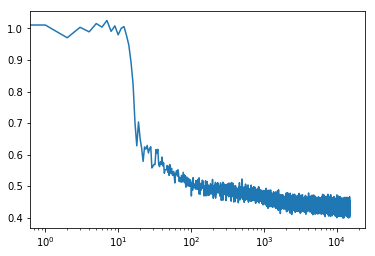

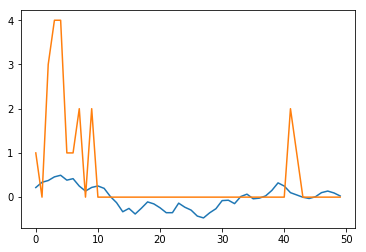

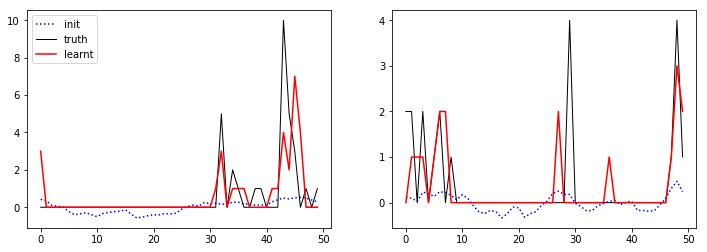

In [45]:
plot(losses[:])
# plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(x[0])
plt.plot(y[0])

plt.figure(figsize = (12, 4))
ii = 990
ax = plt.subplot(1, 2,1)
plt.plot(inits[ii], 'b:', label='init')
plt.plot(finsample[ii], 'k-', lw=1, label='truth')
plt.plot(learn[ii], 'r-', label='learnt')
plt.legend()
ii = 500
ax = plt.subplot(1, 2,2)
plt.plot(inits[ii], 'b:')
plt.plot(finsample[ii], 'k-', lw=1)
plt.plot(learn[ii], 'r-')


In [46]:
np.corrcoef(inits[ii], fins[ii]), np.corrcoef(learn[ii], finsample[ii])


(array([[1.        , 0.86356349],
        [0.86356349, 1.        ]]), array([[1.        , 0.51633263],
        [0.51633263, 1.        ]]))

In [47]:
%%bash
ls modules/
rm -r ./modules/densemodulezapoisson


densemodule
densemoduleza
densemodulezanormal
densemodulezapoisson
specdensemodule
specdensemoduleza
specdensemodulezanormal
specdensemodulezapoisson
testspecnorm
testspecnormfalse
testvanillanorm


In [48]:
module.export('./modules/densemodulezapoisson', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/densemodulezapoisson


# Reconstruct here

In [49]:
kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

def dorecon(yy, xinit, modname, useprior=True, niter=5000, lr=0.001):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon',
                             initializer=xinit, 
                             trainable=True)

    loglik = module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']
#     loglik = -tf.reduce_sum(loglik, axis=-1)
    loglik = -tf.reduce_sum(loglik, axis=(1, 2))
    print(loglik)
    
    xreconk = r2c(xrecon)
    priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=-1)
    prior = tf.multiply(prior, 1/nc, name='prior')
    print(prior)
    

    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        priors = []
        for it in range(niter+1):
            _, l, p = sess.run([opt_op, loss, prior])
            if (np.isnan(l).sum()) : print('NANS')
            if it%1000==0: print(l[0])
            losses.append(l)
            priors.append(p)
        xfin = sess.run(xrecon)
        
    return xfin, losses, priors

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


In [50]:
tf.reset_default_graph()
modname = './modules/densemodulezapoisson//'
xrecons = []
losses = []
priors = []
xinit = []

nstart = 100

ir = [9500]
for ii in ir:
#     ii = 2*i
    seed(300)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = .1*randn(nstart,nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=10000, lr=0.001)
    xrecon = np.squeeze(recons[0])
    xrecons.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinit.append(xi)



INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("Neg:0", shape=(100,), dtype=float32)
Tensor("prior:0", shape=(100,), dtype=float32)
81.86909
11.660301
12.258503
12.212199
11.308569
11.253273
11.680028
11.72888
11.5225115
11.883659
11.510752


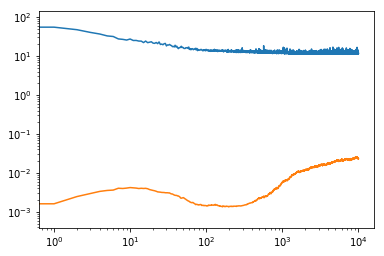

In [51]:
ii = 0
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
plt.yscale('log')
plt.xscale('log')


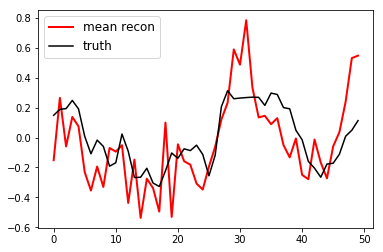

In [52]:
# plt.plot(xrecons[0][10].T, alpha=0.5)
plt.plot(xrecons[0].T.mean(axis=-1), lw=2, color='red', label='mean recon')
plt.plot(inits[ir[0]], 'k', lw=1.5, label='truth')
plt.legend(fontsize=12)
plt.show()

In [53]:
tf.reset_default_graph()
module = hub.Module(modname, trainable=False)

xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']

sess = tf.Session()
sess.run(tf.global_variables_initializer())
reconfins = sess.run(sample, feed_dict={xx:xrecons[0], yy:y})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


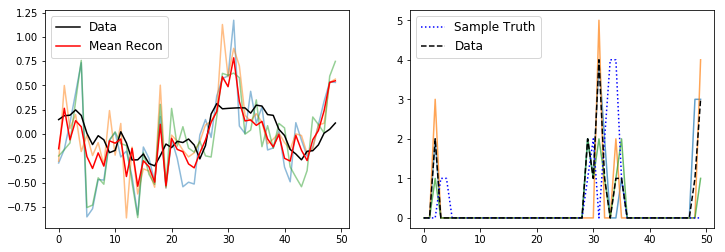

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fsize = 12

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xrecons[0][ii], alpha=0.5)
axis.plot(inits[ir[0]], 'k-', label='Data')
axis.plot(xrecons[0].T.mean(axis=-1), lw=1.5, color='red', label='Mean Recon')
axis.legend(fontsize=fsize)

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(reconfins[ii], alpha=0.7)
plt.plot(learn[ir[0]], 'b:', label='Sample Truth')
plt.plot(finsample[ir[0]], 'k--', label='Data')
plt.legend(fontsize=fsize)

plt.show()

In [55]:
f1 = np.fft.fft(xr)
f2 = np.fft.fft(inits[ir[0]])

NameError: name 'xr' is not defined

In [ ]:
f1.real*f2.real + f1.imag*f2.imag

In [ ]:
xr = xrecons[0].T.mean(axis=1)+1
kk, pp1 = power(xr, boxsize=bs)
kk, pp2 = power(inits[ir[0]]+1, boxsize=bs)
kk, pp12 = power(xr, inits[ir[0]]+1, boxsize=bs)

# plt.plot(kk, pp1)
# plt.plot(kk, pp2)
plt.plot(kk, pp12/(pp1*pp2)**0.5)

xr = xrecons[0][2]
kk, pp1 = power(xr, boxsize=bs)
kk, pp2 = power(inits[ir[0]]+1, boxsize=bs)
kk, pp12 = power(xr, inits[ir[0]]+1, boxsize=bs)

# plt.plot(kk, pp1)
# plt.plot(kk, pp2)
plt.plot(kk, pp12/(pp1*pp2)**0.5)

### Reconstruct with true model

In [ ]:
# kmesh = sum(kk**2 for kk in config['kvec'])**0.5
# priorwt = config['ipklin'](kmesh) * config['boxsize'] ** -3

# def doreconanalytic(yy, xinit, modname, useprior=True, niter=5000, lr=0.001):
#     tf.reset_default_graph()
#     module = hub.Module(modname, trainable=False)

#     xrecon = tf.get_variable('xrecon',
#                              initializer=xinit, 
#                              trainable=True)

#     xreconk = r2c(xrecon)    
#     lap = laplace(config)
#     kweight = gradient(config, 0) * lap
#     dispc = tf.multiply(kweight, xreconk)
#     disp = c2r(dispc)
#     za_t = tf.stack([cic_readout(disp, config['grid'], boxsize=bs)], axis=1)    
    
#     fp_t = tf.add(za_t, config['grid'])
#     zaf_t = tf.zeros_like(xrecon)
#     zaf_t = cic_paint(zaf_t, fp_t, boxsize=bs, name='final')
    
#     predict = tf.add(zaf_t, -1.)
    
#     loglik = tf.reduce_sum(tf.square(tf.add(predict, -yy)), axis=(-1))

#     priormesh = tf.square(tf.cast(tf.abs(xreconk), tf.float32))
#     prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt), axis=-1)
#     prior = tf.multiply(prior, 1/nc, name='prior')


#     if useprior: loss = tf.add(loglik, prior)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
#     opt_op = optimizer.minimize(loss, var_list=[xrecon])


#     with tf.Session() as sess:
#         sess.run(tf.global_variables_initializer())
#         xinit = sess.run(xrecon)
#         losses = []
#         priors = []
#         for it in range(niter+1):
#             _, l, p = sess.run([opt_op, loss, prior])
#             if it%1000==0: print(l)
#             losses.append(l)
#             priors.append(p)
#         xfin = sess.run(xrecon)
        
#     return xfin, losses, priors
# #     with tf.Session() as sess:
# #         sess.run(tf.global_variables_initializer())
        
# #         xfin, llik, pr = sess.run([predict, loglik, prior])
        
# #     return xfin, llik, pr


# tf.reset_default_graph()
# modname = './modules/fwdmodelza//'
# xreconstrue = []
# losses = []
# priors = []
# xinittrue = []

# nstart = 1

# ir = [9500]
# for ii in ir:
# #     ii = 2*i
#     seed(100)
# #     yy = np.array([fins[ii].copy() for j in range(nstart)])
#     yy = fins[ii].copy()
#     for j in range(10):
#         print('Iteration : ', j)
#         xi = randn(nc)
# #         xi = inits[ii].copy()
#         xi = xi.astype('float32')
#         recons = doreconanalytic(yy, xi, modname, useprior=True, niter=5000, lr=0.001)
#         recons2 = doreconanalytic(yy, recons[0], modname, useprior=True, niter=5000, lr=0.0005)
#         xrecon = np.squeeze(recons2[0])
#         xreconstrue.append(xrecon)
#         losses.append(np.squeeze(recons[1] + recons2[1]))
#         priors.append(np.squeeze(recons[2] + recons2[2]))
#         xinittrue.append(xi)



In [ ]:
plt.plot(losses[0])
plt.plot(priors[0])
plt.yscale('log')
plt.xscale('log')

In [ ]:
# plt.plot(xreconstrue[0])
# plt.plot(xreconstrue[1])
# # plt.plot(xreconstrue[0])
# plt.plot(inits[ir[0]], 'k', lw=1.5, label='truth')
# # plt.plot(fins[ir[0]], 'b:', lw=1.5, label='truth')


In [ ]:
# plt.plot(np.array(xreconstrue).mean(axis=0), lw=2, color='red', label='true recon')
# plt.plot(xrecons[0].T.mean(axis=-1), lw=2, color='blue', label='dense recon')
# plt.plot(inits[ir[0]], 'k', lw=1.5, label='truth')
# plt.legend(fontsize=12)
# plt.show()

# Custom dense layer

In [ ]:
# import sys
# sys.path.append('../../utils/')
# import tfops, layers
# from layers import SpecDenseLayer


# tf.reset_default_graph()

# nsize = 256

# def module_fn():
#     '''Define network here'''
#     x = tf.placeholder(tf.float32, shape=[None, nc], name='input')
#     y = tf.placeholder(tf.float32, shape=[None, nc], name='output')


#     net = SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(x)
#     net = net + SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(net)
#     net = net + SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(net)
#     net = net + SpecDenseLayer(nsize, activation=tf.nn.leaky_relu)(net)
#     net = SpecDenseLayer(nc)(net)
#     loglik = tf.reduce_sum(tf.square(tf.add(net, -y)), axis=-1)
#     sample = net
#     #
#     # 
#     inputs = dict(input=x, label=y)
#     outputs = dict(default=net, loglik=loglik, prediction=sample)
#     hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'rate':net})
    
# #####                                                                                                                                                                                                                                                                                     


# spec = hub.create_module_spec(module_fn)
# module = hub.Module(spec, trainable=True)


# xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
# loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
# sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
# loss = loglik
# loss = tf.reduce_mean(loss)

# lr = tf.placeholder(tf.float32)
# optimizer = tf.train.AdamOptimizer(learning_rate=lr)
# train_op = optimizer.minimize(loss)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# losses =[]

# data_size = 10000
# batch_size = 32

# for i in range(10000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = fins[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
#     losses.append(l)
#     if i%1000 ==0: print(l)
# for i in range(10000):
#     inds = np.random.randint(0, data_size, batch_size)
#     x = inits[inds]
#     y = fins[inds]
#     l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.00001})
#     losses.append(l)
#     if i%1000 ==0: print(l)
        
# learnspec = sess.run(rate, feed_dict={xx:inits, yy:y})


In [ ]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv1d as specconv1d


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 128
num_iters = 1
n_mixture = 1
stddev = 0.02
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc], name='output')

    xx = tf.expand_dims(x, -1)

    net = specconv1d(xx, nfilter, 5, num_iters=num_iters, stddev=stddev)
    net = activation=tf.nn.leaky_relu(net)

    net = tf.nn.leaky_relu(net)
    subnet = specconv1d(net, nfilter, 3, name='l11', num_iters=num_iters, stddev=stddev)
    net = net + specconv1d(subnet,nfilter, 3, name='l12', num_iters=num_iters, stddev=stddev)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv1d(net, nfilter, 3, name='l21', num_iters=num_iters, stddev=stddev)
    net = net + specconv1d(subnet,nfilter, 3, name='l22', num_iters=num_iters, stddev=stddev)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv1d(net, nfilter, 3, name='l31', num_iters=num_iters, stddev=stddev)
    net = net + specconv1d(subnet,nfilter, 3, name='l32', num_iters=num_iters, stddev=stddev)
#     net = tf.nn.dropout(net, 0.95)

    net = tf.nn.leaky_relu(net)
    subnet = specconv1d(net, nfilter, 3, name='l41', num_iters=num_iters, stddev=stddev)
    net = net + specconv1d(subnet,nfilter, 3, name='l42', num_iters=num_iters, stddev=stddev)
#     net = tf.nn.dropout(net, 0.95)

    net = specconv1d(net,1, 3, name='l51', num_iters=num_iters)
    net = tf.nn.leaky_relu(net)
#     net = specconv1d(net, n_mixture*3, 1, name='prob')
    
#     loc, unconstrained_scale, logits = tf.split(net,
#                                                     num_or_size_splits=3,
#                                                     axis=-1)
#     scale = tf.nn.softplus(unconstrained_scale)

#     mixture_dist = tfd.MixtureSameFamily(
#         mixture_distribution=tfd.Categorical(logits=logits),
#         components_distribution=tfd.Normal(loc, scale))

#     # Define a function for sampling, and a function for estimating the log likelihood
#     sample = tf.squeeze(mixture_dist.sample())
#     loglik = mixture_dist.log_prob(y)
    
    net = specconv1d(net, 1, 1, name='lograte')
    net = tf.nn.softplus(net)
    mixture_dist = tfd.Poisson(rate=net)
    sample = tf.squeeze(mixture_dist.sample())
    loglik = mixture_dist.log_prob(tf.expand_dims(y, -1))
    
    print(sample, loglik)

    hub.add_signature(inputs={'features':x, 'labels':y}, 
#                           outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
#                                   'scale':scale, 'logits':logits})
                        outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':net})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
# rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik 
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 9000
batch_size = 128

for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    losses.append(l)
    if i%1000 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    losses.append(l)
    if i%1000 ==0: print(l)
for i in range(5000):
    inds = np.random.randint(0, data_size, batch_size)
    x = inits[inds]
    y = finsample[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    losses.append(l)
    if i%1000 ==0: print(l)

        
        
learnspec = sess.run(sample, feed_dict={xx:inits, yy:y})


In [ ]:
plot(losses)
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.figure(figsize = (12, 4))
ii = 9990
ax = plt.subplot(1, 2,1)
plt.plot(inits[ii], 'b--', alpha=0.3)
plt.plot(finsample[ii], 'k-', lw=1)
plt.plot(learn[ii], 'g-.', lw=2, alpha=0.5)
plt.plot(learnspec[ii], 'r-', lw=1.5, label='Spec')
ii = 500
ax = plt.subplot(1, 2,2)
plt.plot(inits[ii], 'b--', alpha=0.3)
plt.plot(finsample[ii], 'k-', lw=1, label='Truth')
plt.plot(learn[ii], 'g-.', lw=2, alpha=0.5, label='Vanilla')
plt.plot(learnspec[ii], 'r-', lw=1.5, label='Spec')
plt.legend()
# ii = 0
# # plt.plot(inits[ii])
# plt.plot(fins[ii], '--', lw=2, label='Final')
# plt.plot(learnspec[ii], ':', lw=2, label='Spec')
# # plt.plot(learnspec[ii]*fins.std(), ':', lw=2, label='Spec')
# plt.plot(learn[ii], 'k-.', label='Vanilla')
# plt.legend()
# plt.show()

In [ ]:
%%bash
ls ./modules/
rm -r ./modules/specdensemodulezapoisson


In [ ]:
module.export('./modules/specdensemodulezapoisson', sess)


## recon again 

In [ ]:
tf.reset_default_graph()
modname = './modules/specdensemodulezapoisson//'
xreconsspec = []
losses = []
priors = []
xinitspec = []

nstart = 100

ir = [9500]
for ii in ir:
#     ii = 2*i
    seed(300)
    yy = np.array([finsample[ii].copy() for j in range(nstart)])
    yy = yy
    xi = 1*randn(nstart,nc)
    xi = xi.astype('float32')
    recons = dorecon(yy, xi, modname, useprior=True, niter=10000, lr=0.001)
    xrecon = np.squeeze(recons[0])
    xreconsspec.append(xrecon)
    losses.append(np.squeeze(recons[1]))
    priors.append(np.squeeze(recons[2]))
    xinitspec.append(xi)



In [ ]:
ii = 50
plt.plot(losses[0][:, ii])
plt.plot(priors[0][:, ii])
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.plot(xreconsspec[0][::10].T, alpha=0.3)
plt.plot(xrecons[0].T.mean(axis=-1), 'b', lw=1, label='mean recon dense')
plt.plot(xreconsspec[0].T.mean(axis=-1), 'r--',lw=2, label='mean recon spec',)
plt.plot(inits[ir[0]], 'k', lw=1.5, label='truth')
plt.legend(fontsize=12)
plt.show()

In [ ]:
tf.reset_default_graph()
module = hub.Module(modname, trainable=False)

xx = tf.placeholder(tf.float32, shape=[None, nc], name='input')
yy = tf.placeholder(tf.float32, shape=[None, nc], name='input')
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']

sess = tf.Session()
sess.run(tf.global_variables_initializer())
reconfinsspec = sess.run(sample, feed_dict={xx:xreconsspec[0], yy:y})



In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xrecons[0][ii], alpha=0.7)
axis.plot(inits[ir[0]], 'k--')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(reconfins[ii], alpha=0.7)
plt.plot(learn[ir[0]], 'r:')
plt.plot(finsample[ir[0]], 'k--')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xreconsspec[0][ii], alpha=0.7)
axis.plot(inits[ir[0]], 'k--')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(reconfinsspec[ii], alpha=0.7)
plt.plot(learnspec[ir[0]], 'r:')
plt.plot(finsample[ir[0]], 'k--')

In [ ]:
# plt.plot(np.array(xreconstrue).mean(axis=0), lw=1, color='c', label='true analytic recon')
plt.plot(xrecons[0].T.mean(axis=-1), lw=1.5, color='red', label='vanilla recon')
plt.plot(xreconsspec[0].T.mean(axis=-1), lw=1.5, color='orange', label='spec recon')
plt.plot(inits[ir[0]], 'k--', lw=2, label='truth')
plt.legend(fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axis= ax[0]
for ii in (1, 5, 10):
    axis.plot(xrecons[0][ii], alpha=0.5)
axis.plot(inits[ir[0]], 'k--')
axis.set_title('Different vanilla recons')

axis= ax[1]
for ii in (1, 5, 10):
    axis.plot(xreconsspec[0][ii], alpha=0.5)
axis.plot(inits[ir[0]], 'k--')
axis.set_title('Different spec normed recons')

In [ ]:
print(np.corrcoef(inits[ir[0]], xreconsspec[0].T.mean(axis=-1)))
print(np.corrcoef(inits[ir[0]], xrecons[0].T.mean(axis=-1)))

# From samples generated by the learned networks

In [154]:
tf.reset_default_graph()
modname = './modules/densemodulezanormal//'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[0]
    print(var)
    kern = sess.run(var)

tf.reset_default_graph()
modname = './modules/specdensemodulezanormal///'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[0]
    print(var)
    kernspec = sess.run(var)
# tf.get_collection('variables')


<tf.Variable 'module/conv1d/kernel:0' shape=(5, 1, 128) dtype=float32>
<tf.Variable 'module/conv1d/w:0' shape=(5, 1, 128) dtype=float32>


In [155]:
def l2normalize(v, eps=1e-12):
    return v / (np.sum(v ** 2) ** 0.5 + eps)

def poweriter(W):
    W_shape = list(W.shape)
    W_reshaped = np.reshape(W, [-1, W_shape[-1]])
    u = np.random.normal(size=W.shape[-1]).reshape(1, W.shape[-1])
    for i in range(100):
        v = l2normalize(np.matmul(u, np.transpose(W_reshaped)))
        u = l2normalize(np.matmul(v, W_reshaped))

    return np.matmul(np.matmul(v, W_reshaped), np.transpose(u))


poweriter(kern) , poweriter(kernspec)

(array([[0.85108967]]), array([[1.68126022]]))

In [563]:


poweriter(kern) , poweriter(kernspec)

(array([[0.83871564]]), array([[0.85677211]]))

# Check specnorm


In [263]:

NO_OPS = 'NO_OPS'


def _l2normalize(v, eps=1e-12):
  return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)


def spectral_normed_weight(W, u=None, num_iters=2, update_collection=None, with_sigma=False):
  # Usually num_iters = 1 will be enough
  W_shape = W.shape.as_list()
  W_reshaped = tf.reshape(W, [-1, W_shape[-1]])
  if u is None:
    u = tf.get_variable("u", [1, W_shape[-1]], initializer=tf.truncated_normal_initializer(), trainable=False)
  def power_iteration(i, u_i, v_i):
    v_ip1 = _l2normalize(tf.matmul(u_i, tf.transpose(W_reshaped)))
    u_ip1 = _l2normalize(tf.matmul(v_ip1, W_reshaped))
    return i + 1, u_ip1, v_ip1
  _, u_final, v_final = tf.while_loop(
    cond=lambda i, _1, _2: i < num_iters,
    body=power_iteration,
    loop_vars=(tf.constant(0, dtype=tf.int32),
               u, tf.zeros(dtype=tf.float32, shape=[1, W_reshaped.shape.as_list()[0]]))
  )
  if update_collection is None:
    warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
                  '. Please consider using a update collection instead.')
    sigma = tf.matmul(tf.matmul(v_final, W_reshaped), tf.transpose(u_final))[0, 0]
    # sigma = tf.reduce_sum(tf.matmul(u_final, tf.transpose(W_reshaped)) * v_final)
    W_bar = W_reshaped / sigma
    with tf.control_dependencies([u.assign(u_final)]):
      W_bar = tf.reshape(W_bar, W_shape)
  else:
    sigma = tf.matmul(tf.matmul(v_final, W_reshaped), tf.transpose(u_final))[0, 0]
    # sigma = tf.reduce_sum(tf.matmul(u_final, tf.transpose(W_reshaped)) * v_final)
    W_bar = W_reshaped / sigma
    W_bar = tf.reshape(W_bar, W_shape)
    # Put NO_OPS to not update any collection. This is useful for the second call of discriminator if the update_op
    # has already been collected on the first call.
    if update_collection != NO_OPS:
      tf.add_to_collection(update_collection, u.assign(u_final))
  if with_sigma:
    return W_bar, sigma
  else:
    return W_bar


def scope_has_variables(scope):
  return len(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=scope.name)) > 0


def conv2d(input_, output_dim,
           k_h=4, k_w=4, d_h=2, d_w=2, stddev=0.02,
           name="conv2d", spectral_normed=False,
           update_collection=tf.GraphKeys.UPDATE_OPS, with_w=False, padding="SAME"):
  # Glorot intialization
  # For RELU nonlinearity, it's sqrt(2./(n_in)) instead
  fan_in = k_h * k_w * input_.get_shape().as_list()[-1]
  fan_out = k_h * k_w * output_dim
  if stddev is None:
    stddev = np.sqrt(2. / (fan_in))

  with tf.variable_scope(name) as scope:
    if scope_has_variables(scope):
      scope.reuse_variables()
    w = tf.get_variable("w", [k_h, k_w, input_.get_shape()[-1], output_dim],
                        initializer=tf.truncated_normal_initializer(stddev=stddev))
    if spectral_normed:
      conv = tf.nn.conv2d(input_, spectral_normed_weight(w, update_collection=update_collection),
                          strides=[1, d_h, d_w, 1], padding=padding)
    else:
      conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding=padding)

    biases = tf.get_variable("b", [output_dim], initializer=tf.constant_initializer(0.0))
    conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

    if with_w:
      return conv, w, biases
    else:
      return conv


In [264]:
testinit = inits.reshape(-1, 50, 50)
testfin = fins.reshape(-1, 50, 50)

In [267]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv1d as specconv1d


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 128
num_iters = 1
n_mixture = 1
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[None, nc, nc], name='output')
    
    xx = tf.expand_dims(x, -1)
    print(xx)



    net = tf.layers.conv2d(xx, nfilter, [3, 3], padding='SAME')
    net = tf.layers.conv2d(net, nfilter, [3, 3], padding='SAME', activation=tf.nn.leaky_relu)
    
    net = tf.nn.leaky_relu(net)
    subnet = tf.layers.conv2d(net, nfilter, [3, 3], padding='SAME')
    net = net + tf.layers.conv2d(subnet,nfilter, [3, 3], padding='SAME')
    net = tf.nn.dropout(net, 0.95)
    net = tf.nn.leaky_relu(net)

    subnet = tf.layers.conv2d(net, nfilter, [3, 3], padding='SAME')
    net = net + tf.layers.conv2d(subnet,nfilter, [3, 3], padding='SAME')
    net = tf.nn.dropout(net, 0.95)
    net = tf.nn.leaky_relu(net)



    net = tf.layers.conv2d(net,1, [3, 3], padding='SAME')
    net = tf.nn.leaky_relu(net)

    net = tf.layers.conv2d(net, n_mixture*3, [3, 3], padding='SAME')
    
    loc, unconstrained_scale, logits = tf.split(net,
                                                    num_or_size_splits=3,
                                                    axis=-1)
    scale = tf.nn.softplus(unconstrained_scale)

    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits),
        components_distribution=tfd.Normal(loc, scale))

    # Define a function for sampling, and a function for estimating the log likelihood
    sample = tf.squeeze(mixture_dist.sample())
    loglik = mixture_dist.log_prob(y)

#

    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
                                  'scale':scale, 'logits':logits})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
print(xx)
yy = tf.placeholder(tf.float32, shape=[None, nc, nc], name='ouptut')
# rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik 
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 200
batch_size = 32

for i in range(1000):
    inds = np.random.randint(0, data_size, batch_size)
    x = testinit[inds]
    y = testfin[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.001})
    losses.append(l)
    if i%1000 ==0: print(l)

        
        
learnspec = sess.run(sample, feed_dict={xx:testinit, yy:y})


In [ ]:
module.export('./modules/testvanillanorm', sess)


In [268]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv1d as specconv1d


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 128
num_iters = 1
n_mixture = 1
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[32, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[32, nc, nc], name='output')
    
    xx = tf.expand_dims(x, -1)
    print(xx)


    net = conv2d(xx, nfilter, 3, 3, 1, 1, padding='SAME', name='l0', spectral_normed=False)
    net = conv2d(net, nfilter, 3, 3, 1, 1, padding='SAME', name='l1', spectral_normed=False)
    
    net = tf.nn.leaky_relu(net)
    subnet = conv2d(net, nfilter, 3, 3, 1, 1, padding='SAME', name='l2', spectral_normed=False)
    net = net + conv2d(subnet,nfilter, 3, 3, 1, 1, padding='SAME', name='l3', spectral_normed=False)
    net = tf.nn.dropout(net, 0.95)
    net = tf.nn.leaky_relu(net)

    subnet = conv2d(net, nfilter, 3, 3, 1, 1, padding='SAME', name='l4', spectral_normed=False)
    net = net + conv2d(subnet,nfilter, 3, 3, 1, 1, padding='SAME', name='l5', spectral_normed=False)
    net = tf.nn.dropout(net, 0.95)
    net = tf.nn.leaky_relu(net)



    net = conv2d(net,1, 3, 3, 1, 1, padding='SAME', name='l6', spectral_normed=False)
    net = tf.nn.leaky_relu(net)

    net = conv2d(net, n_mixture*3, 3, 3, 1, 1, padding='SAME', name='l7', spectral_normed=False)
    
    loc, unconstrained_scale, logits = tf.split(net,
                                                    num_or_size_splits=3,
                                                    axis=-1)
    scale = tf.nn.softplus(unconstrained_scale)

    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits),
        components_distribution=tfd.Normal(loc, scale))

    # Define a function for sampling, and a function for estimating the log likelihood
    sample = tf.squeeze(mixture_dist.sample())
    loglik = mixture_dist.log_prob(y)

#

    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
                                  'scale':scale, 'logits':logits})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
print(xx)
yy = tf.placeholder(tf.float32, shape=[None, nc, nc], name='ouptut')
# rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik 
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 200
batch_size = 32

for i in range(1002):
    inds = np.random.randint(0, data_size, batch_size)
    x = testinit[inds]
    y = testfin[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    losses.append(l)
    if i%1000 ==0: print(l)

        
        
# learnspec = sess.run(sample, feed_dict={xx:testinit, yy:y})


Tensor("ExpandDims:0", shape=(32, 50, 50, 1), dtype=float32)
Tensor("input:0", shape=(?, 50, 50), dtype=float32)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.6043152
-0.6481911


In [269]:
%%bash 
rm -r ./modules/testspecnormfalse

In [270]:
module.export('./modules/testspecnormfalse', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/testspecnormfalse


In [271]:
import sys
sys.path.append('../../utils/')
import tfops, layers
from layers import SpecDenseLayer
from tfops import specnormconv1d as specconv1d


#####                                                                                                                                                                                                                                                                                     

tf.reset_default_graph()

nfilter = 128
num_iters = 1
n_mixture = 1
def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[32, nc, nc], name='input')
    y = tf.placeholder(tf.float32, shape=[32, nc, nc], name='output')
    
    xx = tf.expand_dims(x, -1)
    print(xx)


    net = conv2d(xx, nfilter, 3, 3, 1, 1, padding='SAME', name='l0')
    net = conv2d(net, nfilter, 3, 3, 1, 1, padding='SAME', name='l1')
    
    net = tf.nn.leaky_relu(net)
    subnet = conv2d(net, nfilter, 3, 3, 1, 1, padding='SAME', name='l2')
    net = net + conv2d(subnet,nfilter, 3, 3, 1, 1, padding='SAME', name='l3')
    net = tf.nn.dropout(net, 0.95)
    net = tf.nn.leaky_relu(net)

    subnet = conv2d(net, nfilter, 3, 3, 1, 1, padding='SAME', name='l4')
    net = net + conv2d(subnet,nfilter, 3, 3, 1, 1, padding='SAME', name='l5')
    net = tf.nn.dropout(net, 0.95)
    net = tf.nn.leaky_relu(net)



    net = conv2d(net,1, 3, 3, 1, 1, padding='SAME', name='l6')
    net = tf.nn.leaky_relu(net)

    net = conv2d(net, n_mixture*3, 3, 3, 1, 1, padding='SAME', name='l7')
    
    loc, unconstrained_scale, logits = tf.split(net,
                                                    num_or_size_splits=3,
                                                    axis=-1)
    scale = tf.nn.softplus(unconstrained_scale)

    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits),
        components_distribution=tfd.Normal(loc, scale))

    # Define a function for sampling, and a function for estimating the log likelihood
    sample = tf.squeeze(mixture_dist.sample())
    loglik = mixture_dist.log_prob(y)

#

    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'loc':loc, 
                                  'scale':scale, 'logits':logits})
    
    
#####                                                                                                                                                                                                                                                                                     


spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)


xx = tf.placeholder(tf.float32, shape=[None, nc, nc], name='input')
print(xx)
yy = tf.placeholder(tf.float32, shape=[None, nc, nc], name='ouptut')
# rate = module({'features':xx, 'labels':yy}, as_dict=True)['rate']
loglik = module({'features':xx, 'labels':yy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':yy}, as_dict=True)['sample']
loss = -loglik 
loss = tf.reduce_mean(loss)

lr = tf.placeholder(tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]



data_size = 200
batch_size = 32

for i in range(1002):
    inds = np.random.randint(0, data_size, batch_size)
    x = testinit[inds]
    y = testfin[inds]
    l,_= sess.run([loss, train_op], feed_dict={xx:x, yy:y, lr:0.0001})
    losses.append(l)
    if i%1000 ==0: print(l)

        
        
# learnspec = sess.run(sample, feed_dict={xx:testinit, yy:y})


Tensor("ExpandDims:0", shape=(32, 50, 50, 1), dtype=float32)
Tensor("input:0", shape=(?, 50, 50), dtype=float32)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0.6045598
-0.69147694


In [272]:
%%bash
rm -r ./modules/testspecnorm/

In [273]:
module.export('./modules/testspecnorm', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/testspecnorm


In [276]:
tf.reset_default_graph()
modname = './modules/testspecnormfalse///'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[0]
    print(var)
    kern = sess.run(var)

tf.reset_default_graph()
modname = './modules/testspecnorm///'
module = hub.Module(modname, trainable=False)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    var = tf.get_collection('variables')[0]
    print(var)
    kernspec = sess.run(var)
# tf.get_collection('variables')


<tf.Variable 'module/l0/w:0' shape=(3, 3, 1, 128) dtype=float32>
<tf.Variable 'module/l0/w:0' shape=(3, 3, 1, 128) dtype=float32>


In [277]:
def l2normalize(v, eps=1e-12):
    return v / (np.sum(v ** 2) ** 0.5 + eps)

def poweriter(W):
    W_shape = list(W.shape)
    W_reshaped = np.reshape(W, [-1, W_shape[-1]])
    np.random.seed(100)
    u = np.random.normal(size=W.shape[-1]).reshape(1, W.shape[-1])
    for i in range(100):
        v = l2normalize(np.matmul(u, np.transpose(W_reshaped)))
        u = l2normalize(np.matmul(v, W_reshaped))

    return np.matmul(np.matmul(v, W_reshaped), np.transpose(u))


poweriter(kern) , poweriter(kernspec)

(array([[0.32160636]]), array([[0.29847285]]))

In [254]:
np.linalg.eigvals(kern.reshape(-1, nfilter))

LinAlgError: Last 2 dimensions of the array must be square